In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据集

给定$x$，我们将使用以下三阶多项式来生成训练和测试数据的标签：

$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$

噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。
在优化的过程中，我们通常希望避免非常大的梯度值或损失值。
这就是我们将特征从$x^i$调整为$\frac{x^i}{i!}$的原因，
这样可以避免很大的$i$带来的特别大的指数值。
我们将为训练集和测试集各生成100个样本。

In [4]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集的大小
true_w = np.zeros(max_degree)  # 分配大量空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size = (n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度：(n_train + n_test)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale = 0.1, size = labels.shape)

存储在poly_features中的单项式由gamma函数重新缩放，
其中$\Gamma(n)=(n-1)!$。
从生成的数据集中查看一下前2个样本，
第一个值是与偏置相对应的常量特征。

In [5]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

In [6]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.2565],
         [-2.2676]]),
 tensor([[ 1.0000e+00, -1.2565e+00,  7.8936e-01, -3.3060e-01,  1.0385e-01,
          -2.6096e-02,  5.4648e-03, -9.8091e-04,  1.5406e-04, -2.1508e-05,
           2.7024e-06, -3.0868e-07,  3.2321e-08, -3.1238e-09,  2.8036e-10,
          -2.3484e-11,  1.8442e-12, -1.3630e-13,  9.5145e-15, -6.2919e-16],
         [ 1.0000e+00, -2.2676e+00,  2.5709e+00, -1.9433e+00,  1.1016e+00,
          -4.9960e-01,  1.8881e-01, -6.1164e-02,  1.7337e-02, -4.3681e-03,
           9.9049e-04, -2.0418e-04,  3.8583e-05, -6.7300e-06,  1.0901e-06,
          -1.6479e-07,  2.3354e-08, -3.1151e-09,  3.9243e-10, -4.6835e-11]]),
 tensor([ -1.1486, -17.5782]))

### 对模型进行训练和测试

首先实现一个函数来评估模型在给定数据集上的损失

In [7]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [8]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 三阶多项式函数拟合（正常）

首先使用三阶多项式函数，它与数据生成函数的阶数相同。
结果表明，该模型能有效降低训练损失和测试损失。
学习到的模型参数也接近真实值$w = [5, 1.2, -3.4, 5.6]$。

weight: [[ 5.016911   1.2140008 -3.4260864  5.581189 ]]


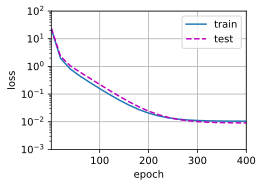

In [9]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### 线性函数拟合（欠拟合）

当用于拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。

weight: [[3.6582568 3.967709 ]]


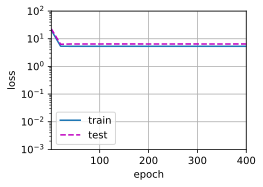

In [10]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### 高阶多项式函数拟合（过拟合）

尝试使用一个阶数过高的多项式来训练模型。在这种情况下，没有足够的数据用于学习高阶系数应该具有接近于零的值。因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。虽然训练损失可以有效地降低，但测试损失仍然很高。结果表明，复杂模型对数据造成了过拟合。

weight: [[ 5.0074177   1.2689897  -3.3731365   5.1744385  -0.28380862  1.3880066
   0.28433597  0.23886798  0.10456859 -0.01008706 -0.13444044 -0.00965116
  -0.09757714 -0.09527045  0.21342376  0.13767722 -0.08204057 -0.10666441
   0.12475184  0.21017507]]


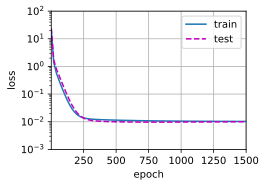

In [11]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)